## Imports

In [1]:
import datetime
import functools
import os

import numpy as np
import pandas as pd

import scipy.stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['text.usetex'] = True

from lvml.experiment import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Load analysis files

In [2]:
from glob import glob
import pickle

n_runs = 10
dataset = 'movielens'

get_seed = lambda f: int(f.split('/')[-2].split('_')[-1].split('.')[0])
output_dir = os.path.expanduser(f'~/Documents/lvml/output/{dataset}_*/')
file_list = lambda basename: sorted([p for p in glob(f'{output_dir}/{basename}') if get_seed(p)>=0], key=get_seed)[:n_runs]

In [3]:
read_csvs = lambda basename: pd.concat([
    pd.read_csv(f).assign(seed=get_seed(f))
    for f in file_list(basename)
])

read_pickles = lambda basename: {
    get_seed(f): pickle.load(open(f,'rb'))
    for f in file_list(basename)
}


results_df_combined = read_csvs('results_df.csv.zip')
optimizer_variations_results_df_combined = read_csvs('sensitivity_df.csv.zip')
adaptive_results_df_combined = read_csvs('adaptive_results_df.csv.zip')
true_ratings_results_df_combined = read_csvs('true_ratings_results_df.csv.zip')
safety_res_all = read_pickles('safety.pkl')
params_all = read_pickles('params.pkl')

## Prepare plots

In [4]:
selected_simulator = 'discrete'
selected_kappa = 0.5
selected_predictor = 'linear_regression'
selected_safety_threshold_high = 16
selected_safety_threshold_low = 14
selected_T0 = 5.0

confidence_interval_alpha = 0.05

myopic_means = (
    results_df_combined
    .query('simulator=="discrete" and policy=="myopic" and predictor=="linear_regression" and kappa==@selected_kappa')
    .groupby('seed')
    ['rate']
    .mean()
)

confidence_interval = lambda s: sm.stats.DescrStatsW(s).tconfint_mean(confidence_interval_alpha)

In [5]:
prediction_policy_comparison_df = (
    results_df_combined
    .query('simulator==@selected_simulator and kappa==@selected_kappa')
    .pivot(
        index='user_ind',
        columns=['predictor','policy','seed'],
        values='rate',
    )
    .mean()
    .pipe(lambda s: s/s.loc[(selected_predictor,'myopic',slice(None))])
    .unstack()
    .apply(
        lambda row: pd.Series(
            {
                'mean': row.mean(),
                'yerr': confidence_interval(row)[1]-row.mean()
            }
        ),
        axis=1,
    )
)

safety_df = (
    pd.DataFrame(safety_res_all)
    .apply(lambda s: s.map(lambda arr: arr.mean()/myopic_means.loc[s.name]))
    .apply(
        lambda row: pd.Series(
            {
                'mean': row.mean(),
                'yerr': confidence_interval(row)[1]-row.mean()
            }
        ),
        axis=1,
    )
    .reset_index()
    .assign(policy='safety')
    .set_index(['policy','index'])
)

adaptive_full_df = (
    pd.concat([
        results_df_combined.assign(sampling_rate=1.0, T0=0),
        true_ratings_results_df_combined.assign(sampling_rate=1.0, T0=0),
        adaptive_results_df_combined,
    ])
    .query('simulator==@selected_simulator and kappa==@selected_kappa')
    .pivot(
        index='user_ind',
        columns=['predictor','policy','sampling_rate', 'T0','seed'],
        values='rate',
    )
    .mean()
    .sort_index()
    .pipe(lambda s: s/s.loc[(selected_predictor,'myopic',1.0,0)])
    .unstack()
    .apply(
        lambda row: pd.Series(
            {
                'mean': row.mean(),
                'yerr': confidence_interval(row)[1]-row.mean()
            }
        ),
        axis=1,
    )
)

adaptive_df = (
    adaptive_full_df
    .xs(selected_predictor)
    .xs('lv_engagement_adaptive',level=0, drop_level=False)
    .xs(1.0, level=1)
)

barplot_comparison_df=pd.concat([prediction_policy_comparison_df,safety_df,adaptive_df])
barplot_comparison_df

mean      yerr
predictor              policy                           
dummy                  argmax         1.032508  0.002842
                       lv_engagement  1.036757  0.001822
                       myopic         1.000041  0.000071
gradient_boosting      argmax         1.036986  0.000853
                       lv_engagement  1.047633  0.003375
                       myopic         1.000071  0.000111
linear_regression      argmax         1.039301  0.001125
                       lv_engagement  1.059762  0.002203
                       myopic         1.000000  0.000000
oracle                 argmax         1.044142  0.000628
                       lv_engagement  1.067673  0.001282
                       myopic         0.999929  0.000095
safety                 14             0.995896  0.000167
                       15             1.005274  0.000328
                       16             1.002366  0.000406
                       17             1.000101  0.000173
                       18             1.000011  0.000134
                       19             1.000070  0.000089
                       20             0.999979  0.000124
lv_engagement_adaptive 0.5            1.061108  0.001820
                       5.0            1.063528  0.001485
                       50.0           1.060117  0.001176

Figure saved as ./figures/movielens_experiment.pdf


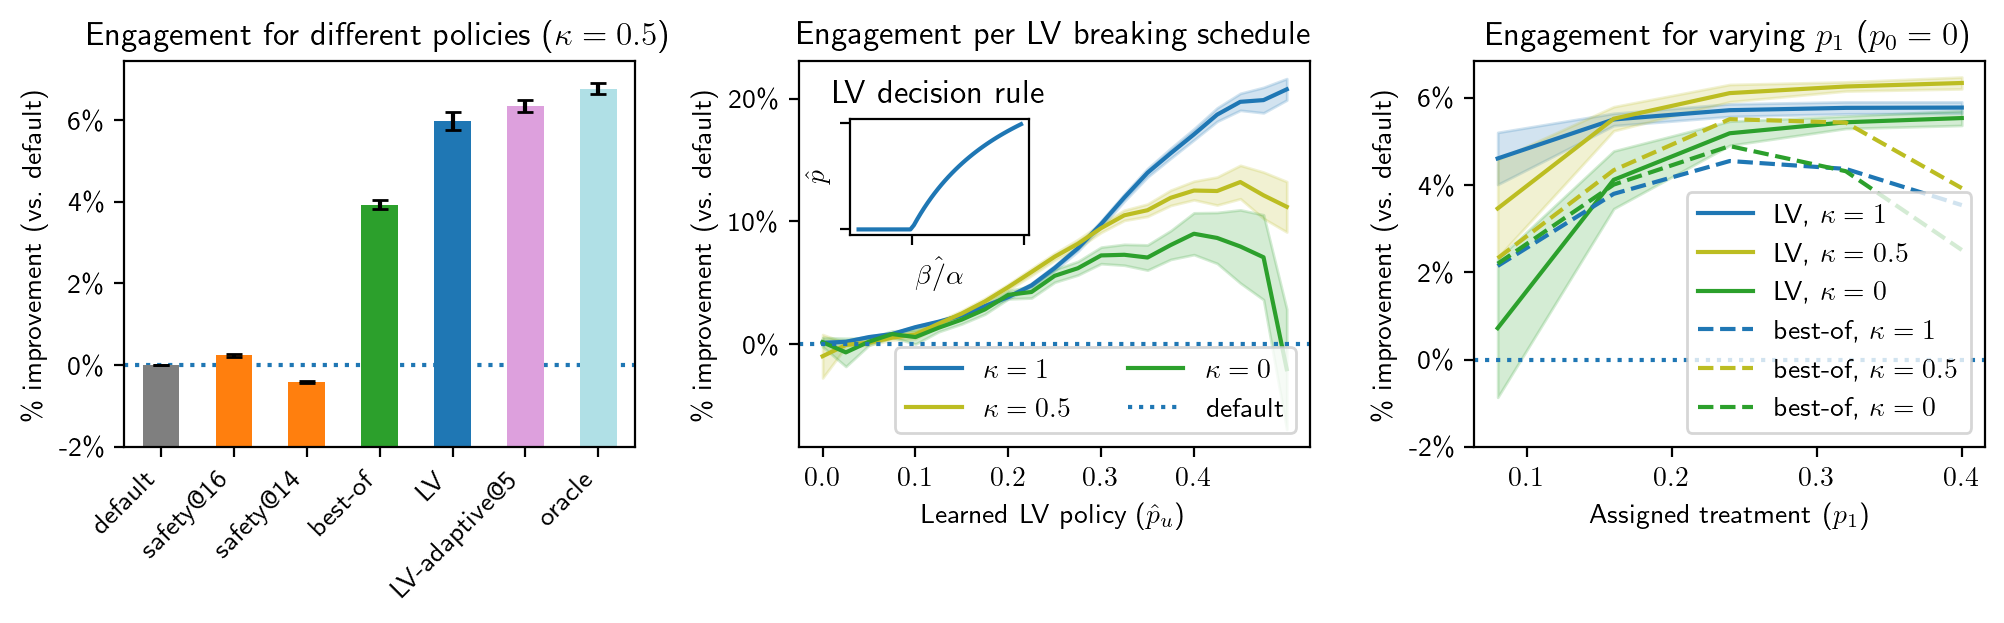

In [6]:
kappa_colors={
    ('lv_engagement',1.0): 'tab:blue',
    ('lv_engagement',0.5): 'tab:olive',
    ('lv_engagement',0.0): 'tab:green',
    ('argmax',1.0): 'tab:red',
    ('argmax',0.5): 'tab:pink',
    ('argmax',0.0): 'tab:orange',
}

bar_plot_config={
    'default': ((selected_predictor,'myopic'), 'tab:gray', ''),
    f'safety@{selected_safety_threshold_high}': (('safety',selected_safety_threshold_high), 'tab:orange', ''),
    f'safety@{selected_safety_threshold_low}': (('safety',selected_safety_threshold_low), 'tab:orange', ''),
    'best-of': ((selected_predictor,'argmax'), 'tab:green', ''),
    'LV': ((selected_predictor,'lv_engagement'), 'tab:blue', ''),
    f'LV-adaptive@{selected_T0:.2g}': (('lv_engagement_adaptive',selected_T0), 'plum', ''),
    'oracle': (('oracle','lv_engagement'), 'powderblue', ''),
}


fig,axs=subplots_latex(
    1,3,
    row_width_type='textwidth',
    row_height_factor=0.195,
    tight_layout=dict(w_pad=2)
)

def plot_barplot_comparison(ax):
    (
        barplot_comparison_df
        .loc[[t[0] for t in bar_plot_config.values()]]
        .pipe(lambda df: df['mean'].plot.bar(
            ax=ax,
            color=[t[1] for t in bar_plot_config.values()],
            hatch=[t[2] for t in bar_plot_config.values()],
            yerr=df['yerr'],
            capsize=3,
        ))
    )
    ax.axhline(1,linestyle=':',zorder=-1)
    ax.set(
        ylim=(0.98,1+(barplot_comparison_df['mean'].max()-1)*1.1),
    )
    ax.set_xticklabels(
        [n for n in bar_plot_config],
        rotation=45,
        ha='right',
        va='top',
    )
    ax.set(
        title=f'Engagement for different policies ($\kappa={selected_kappa}$)',
        xlabel=None,
    )
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,pos: f'{round((x-1)*100)}\%'))
    return ax

plot_barplot_comparison(axs[0])

#
# Engagement vs. p
#

def plot_selected_policies(ax):
    for selected_kappa in [1.0,0.5,0.0]:
        (
            results_df_combined
            .query('simulator==@selected_simulator and kappa==@selected_kappa and predictor==@selected_predictor')
            .pipe(lambda df: pd.concat(
                [
                    (
                        df
                        .pivot(
                            index=['seed','user_ind'],
                            columns='policy',
                            values='rate',
                        )
                        .apply(lambda row: row['lv_engagement']/(row['myopic']+1e-5)-1,axis=1)
                        .rename('gain')
                    ),
                    (
                        df
                        .query('policy=="lv_engagement"')
                        .set_index(['seed','user_ind'])
                        ['p_fb']
                    ),
                ],
                axis=1,
            ))
            .query('p_fb>1e-5')
            .assign(
                p_group=lambda df: quantize(df['p_fb'], res=0.025)
            )
            .groupby('p_group')
            ['gain']
            .agg([
                ('mean', 'mean'),
                ('ci', lambda s: confidence_interval(s)),
            ])
            .pipe(lambda df: [
                df['mean'].plot.line(
                    ax=ax,
                    label=f'$\kappa={selected_kappa:.1g}$',
                    color=kappa_colors[('lv_engagement',selected_kappa)],
                ),
                ax.fill_between(
                    df.index, 
                    df['ci'].map(lambda t: t[0]),
                    df['ci'].map(lambda t: t[1]),
                    alpha=0.2,
                    color=kappa_colors[('lv_engagement',selected_kappa)],
                )
            ])
        )

    ax.axhline(0, linestyle=':', label='default')
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,pos: f'{round(x*100)}\%'))
    ax.set(
        title='Engagement per LV breaking schedule',
        xlabel=r'Learned LV policy ($\hat{p}_u$)',
        xticks=np.arange(0,0.5,0.1)
    )

    ax.legend(
        loc='lower right',
        ncol=2,
    )


    axins = ax.inset_axes([0.1, 0.55, 0.35, 0.3])
    ba_theory_vec = np.linspace(1,4)[1:-1]
    ab_theory_vec = 1/ba_theory_vec
    axins.plot(ba_theory_vec, p_opt_f(ab_theory_vec))
    axins.set(
        title='LV decision rule',
        xlabel=r'$\hat{\beta/\alpha}$',
        ylabel=r'$\hat{p}$',
    )
    plt.setp(axins.get_xticklabels(), visible=False)
    plt.setp(axins.get_yticklabels(), visible=False)
    return ax, axins

plot_selected_policies(axs[1])

#
# Sensitivity
#

def plot_sensitivity(ax):
    for selected_policy, display_name in [('lv_engagement','LV'), ('argmax','best-of')]:
        for selected_kappa in [1.0,0.5,0.0]:
            color = kappa_colors[('lv_engagement',selected_kappa)]
            linestyle = '-' if selected_policy=='lv_engagement' else '--'
            (
                optimizer_variations_results_df_combined
                .query('predictor=="linear_regression" and mode=="two-treatment" and kappa==@selected_kappa')
                .drop(['predictor','mode','kappa'],axis=1)
                .groupby(['seed','p1','policy'])
                ['rate']
                .mean()
                .unstack()
                .apply(lambda row: row/row['myopic']-1, axis=1)
                .drop('myopic', axis=1)
                .groupby(level=1)
                .agg([
                    ('mean', 'mean'),
                    ('ci', lambda s: confidence_interval(s)),
                ])
                [selected_policy]
                .pipe(lambda df: [
                    df['mean'].plot.line(
                        ax=ax,
                        label=f'{display_name}, $\kappa={selected_kappa:.1g}$',
                        color=color,
                        linestyle=linestyle,
                    ),
                    ax.fill_between(
                        df.index, 
                        df['ci'].map(lambda t: t[0]),
                        df['ci'].map(lambda t: t[1]),
                        alpha=0.2,
                        color=color,
                    ) if selected_policy=='lv_engagement' else None
                ])
            )

    ax.axhline(0,linestyle=':')
    ax.legend(
        loc='lower right',
    )
    ax.set(
        title='Engagement for varying $p_1$ ($p_0=0$)',
        xlabel='Assigned treatment ($p_1$)',
        ylabel=r'\% improvement - engagement',
        ylim=(-0.02,None),
    )
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,pos: f'{round(x*100)}\%'))
    return ax

plot_sensitivity(axs[2])

for i,ax in enumerate(axs):
    ax.set(
        ylabel=r'\% improvement (vs. default)',
    )
    
fig.save_and_download(f'./figures/{dataset}_experiment.pdf')

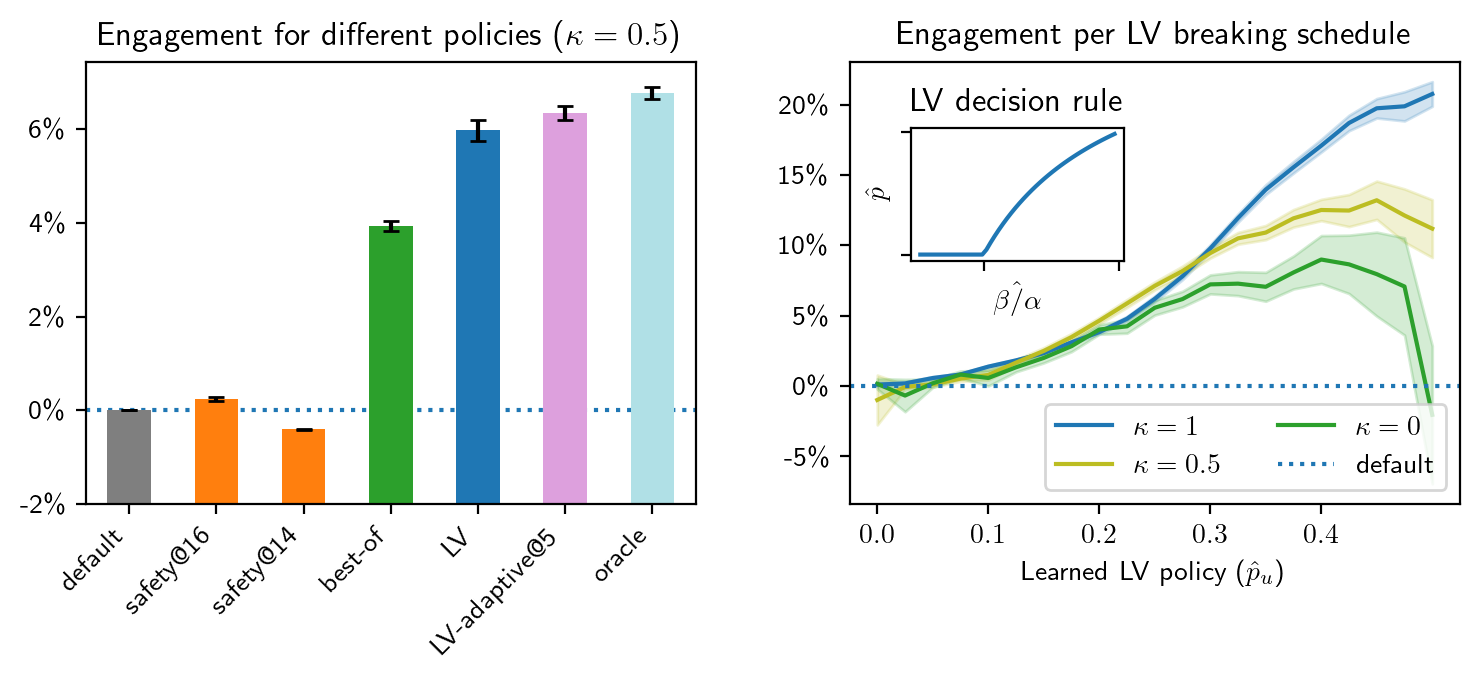

In [7]:
fig,axs=create_fig(1,2,figsize=(7.5,3.5))
plot_barplot_comparison(axs[0])
plot_selected_policies(axs[1])
fig.download(f'poster_{dataset}_experiment.pdf')

## Adaptive policy

Figure saved as ./figures/movielens_adaptive_policy_experiment.pdf


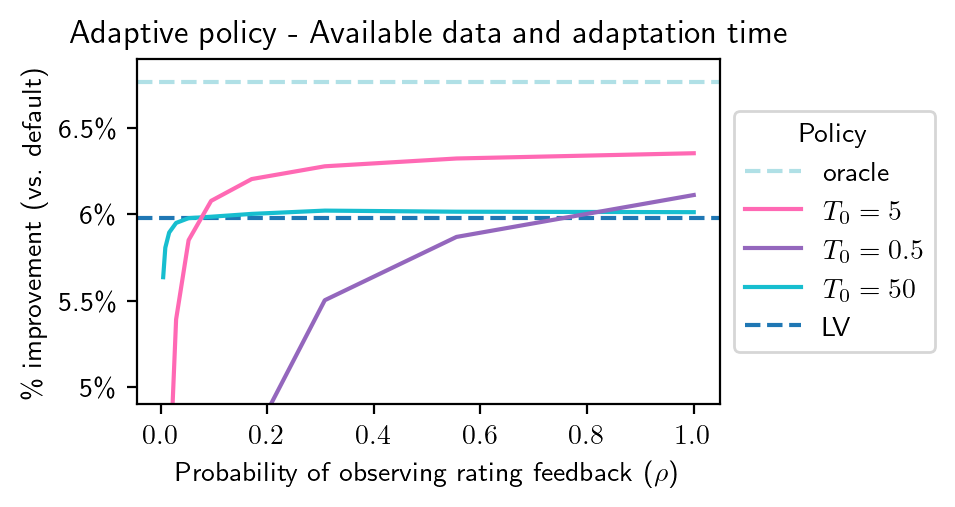

In [8]:
policy_color_config={
    # (selected_predictor,'myopic'): ('default', 'tab:gray', '--'),
    # (selected_predictor,'argmax'): ('best-of', 'tab:green', ':'),
    (selected_predictor,'lv_engagement'): ('LV', 'tab:blue', '--'),
    # (selected_predictor,'lv_engagement_adaptive'): ('LV-adaptive', 'tab:purple', ':'),
    # (selected_predictor,'lv_engagement_true_ratings'): ('LV-true-ratings', 'tab:cyan', ':'),
    ('oracle','lv_engagement'): ('oracle', 'powderblue', '--'),
}

T0_vec = [5,0.5,50]
fig,ax=subplots_latex(
    1,1,
    row_width_type='columnwidth',
    row_height_factor=0.16,
)

adaptive_with_yerr = (
    adaptive_full_df
    .loc[(selected_predictor,'lv_engagement_adaptive')]
    .unstack()
    .swaplevel(axis=1)
    .sort_index(axis=1)
    # .plot.line(ax=ax)
    # .xs('lv_engagement_adaptive',level=1)
)

for i,T0 in enumerate(T0_vec):
    c = [
        'hotpink',
        'tab:purple',
        'tab:cyan',
    ][i]
    adaptive_with_yerr[T0]['mean'].plot.line(
        label=f'$T_0={T0:.2g}$',
        color=c,
        zorder=-i,
    )

for policy, (label, c, ls) in policy_color_config.items():
    ax.axhline(
        adaptive_full_df.loc[policy]['mean'].iloc[0],
        zorder=-10,
        label=label,
        color=c,
        linestyle=ls,
    )

handles, labels = ax.get_legend_handles_labels()
order = [4,0,1,2,3]
assert len(order)==len(labels)
ax.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    title='Policy',
)

ax.set(
    # xscale='log',
    xlabel='Probability of observing rating feedback ($\\rho$)',
    ylabel=r'\% improvement (vs. default)',
    title=f'Adaptive policy - Available data and adaptation time',
    # ylim=(0.985,None)
    # ylim=(1.038,None)
    ylim=(1.049,1.069)
)

ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,pos: f'{(x-1)*100:.2g}\%'))
fig.save_and_download(f'./figures/{dataset}_adaptive_policy_experiment.pdf')

## Combine params

In [9]:
base_seed = min(params_all)
keys = sorted(params_all[base_seed].keys())
combined_params = {}
for k in keys:
    if k in ['random_state']:
        continue
    if all(np.allclose(d[k],params_all[base_seed][k]) for d in params_all.values()):
        combined_params[k] = params_all[base_seed][k] 
    elif not hasattr(params_all[base_seed][k], '__iter__'):
        print(f'Averaging {k}')
        vals = np.array([d[k] for d in params_all.values()])
        print(f'mean={vals.mean():.3g}, std={vals.std():.2g}')
        combined_params[k] = vals.mean() if not isinstance(params_all[base_seed][k], int) else round(vals.mean())
    else:
        print(f'Skipping {k}')
        print([d[k] for d in params_all.values()])


Averaging cf_rmse
mean=0.917, std=0.00084
Averaging total_simulation_time_minutes
mean=28.1, std=9.5


In [10]:
performance_comparison_pct_df = (
    barplot_comparison_df
    .loc[([selected_predictor,'oracle','safety','lv_engagement_adaptive'], slice(None)),'mean']
    .pipe(lambda s: s.loc[(selected_predictor,'lv_engagement')]-s)
    .apply(lambda s: s*100)
)

adaptive_performance_comparison_pct_df = (
    barplot_comparison_df
    .loc[([selected_predictor,'oracle','safety','lv_engagement_adaptive'], slice(None)),'mean']
    .pipe(lambda s: s.loc[('lv_engagement_adaptive',selected_T0)]-s)
    .apply(lambda s: s*100)
)

confidence_level_df = (
    barplot_comparison_df
    .loc[([selected_predictor,'oracle','safety','lv_engagement_adaptive'], slice(None)),'yerr']
    .apply(lambda s: s*100)
)

combined_params['overall_improvement_over_myopic'] = performance_comparison_pct_df.loc[(selected_predictor, 'myopic')]
combined_params['overall_improvement_over_argmax'] = performance_comparison_pct_df.loc[(selected_predictor, 'argmax')]
combined_params['overall_improvement_over_oracle'] = performance_comparison_pct_df.loc[('oracle', 'lv_engagement')]
combined_params['overall_improvement_over_safety'] = performance_comparison_pct_df.loc[('safety', selected_safety_threshold_high)]
combined_params['overall_improvement_over_adaptive'] = performance_comparison_pct_df.loc[('lv_engagement_adaptive', selected_T0)]
combined_params['overall_improvement_over_adaptive_neg'] = -combined_params['overall_improvement_over_adaptive']
combined_params['adaptive_improvement_over_myopic'] = adaptive_performance_comparison_pct_df.loc[(selected_predictor, 'myopic')]

combined_params['overall_improvement_over_myopic_confidence'] = confidence_level_df.loc[(selected_predictor, 'myopic')]
combined_params['overall_improvement_over_argmax_confidence'] = confidence_level_df.loc[(selected_predictor, 'argmax')]
combined_params['overall_improvement_over_oracle_confidence'] = confidence_level_df.loc[('oracle', 'lv_engagement')]
combined_params['overall_improvement_over_safety_confidence'] = confidence_level_df.loc[('safety', selected_safety_threshold_high)]
combined_params['overall_improvement_over_adaptive_confidence'] = confidence_level_df.loc[('lv_engagement_adaptive', selected_T0)]

combined_params['num_repetitions'] = len(params_all)
combined_params['confidence_interval_alpha'] = confidence_interval_alpha
combined_params['confidence_level_pct'] = round(100*(1-confidence_interval_alpha))

In [11]:
pickle.dump(combined_params, open(f'./output/{dataset}_combined_params.pkl','wb'))